## Random Forest, Gradient, Light, XG & Adaptative Boosting_K40_05NOV2020

### Carregando as Bibliotecas

In [1]:
! pip install lightgbm
! pip install xgboost

In [2]:
import plotly_express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy
import seaborn as sns
import statsmodels
import statsmodels.stats.api as sms

In [3]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [4]:
# parâmetros dos gráficos para o arquivo
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
%matplotlib inline
plt.rcParams.update(params)

### Arquivo_02

In [5]:
df=pd.read_csv('d_f_a_2.csv',encoding = "ISO-8859-1", sep=";", low_memory=False, nrows=1000000)
# somente 100 mil linhas, tempo computação adequável

In [6]:
# separação na doença mais frequente desse arquivo = K40
temp = np.where(df['diag_princ'].isin(['K40']))
df40 = df.loc[temp]
# reunir tudo
df40.head(3)

cod_muni  qtd_mora  incidencia diag_princ  prevalencia  renda_media_mora  \
18    290010      8301          24        K40     0.002891          0.103943   
53    290020     16991          50        K40     0.002943          0.036980   
98    290030     14503          97        K40     0.006688          0.063205   

    SITU1_entorno  SITU2_entorno  SITU3_entorno  SITU4_entorno  ...  \
18       0.463481            0.0            0.0            0.0  ...   
53       0.548910            0.0            0.0            0.0  ...   
98       0.887555            0.0            0.0            0.0  ...   

    V032_domicilio02  V033_domicilio02  V034_domicilio02  V035_domicilio02  \
18          0.005892          0.399110          0.016835          0.035354   
53          0.109294          0.194620          0.004395          0.249180   
98          0.006756          0.374053          0.024022          0.037399   

    V036_domicilio02  V037_domicilio02  V038_domicilio02  V041_domicilio02  \
18          0.000000          0.010582          0.970779          0.027417   
53          0.000176          0.024848          0.909341          0.086381   
98          0.000409          0.006142          0.970859          0.018904   

    V045_domicilio02  V089_domicilio02  
18          0.490861          0.509139  
53          0.501875          0.498125  
98          0.491913          0.508087  

[3 rows x 83 columns]

In [7]:
# Preparação dos arquivos de entrada (X) e saída (y)
X = df40.drop(columns=['prevalencia','diag_princ','incidencia'])
y = df40.loc[:,'prevalencia']

In [8]:
# Divisão entre arquivos de treino e teste, com corte em 30%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3, random_state=1234)

In [9]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

<AxesSubplot:>

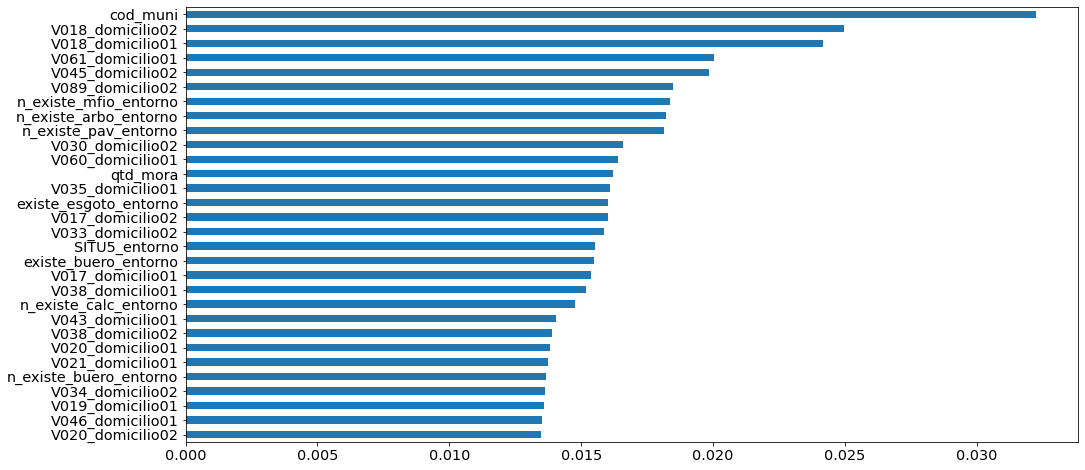

In [10]:
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(30).sort_values().plot.barh())

### Seleção de atributos  - acima da importância de (não_exixte_pav_entorno): vide acima

In [12]:
# Preparação dos arquivos de entrada (X) e saída (y)
# Código do município foi retirado
X = df40[["V018_domicilio02",'V018_domicilio01',"V061_domicilio01",'V045_domicilio02',"V089_domicilio02","n_existe_mfio_entorno",
           'n_existe_arbo_entorno',"n_existe_pav_entorno"]]
y = df40.loc[:,'prevalencia']

### Algoritmo Referência = Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [14]:
params_grid= {'n_estimators':[2,3,4,5,6,7,8,9,10],
              "max_features":['auto'],
              'max_depth':[10,20,30],
              'max_leaf_nodes':[2,3,4,5],
              'min_samples_leaf':[5,10,15],
              'min_samples_split':[3,6,9,12,15,18,21]}
random_rf = RandomizedSearchCV(estimator = rf,cv=10,param_distributions=params_grid,n_iter=100,verbose=2,n_jobs=-1)
random_rf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.8s finished
C:\Users\aferr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [15]:
random_rf.best_params_

{'n_estimators': 10,
 'min_samples_split': 15,
 'min_samples_leaf': 15,
 'max_leaf_nodes': 5,
 'max_features': 'auto',
 'max_depth': 20}

In [16]:
m_rf=RandomForestRegressor(n_estimators= 9,
 min_samples_split = 9,
 min_samples_leaf = 15,
 max_leaf_nodes = 5,
 max_features ='auto',
 max_depth = 20)

In [17]:
yrf = m_rf.fit(X_train,y_train)
print(yrf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=5,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=15, min_samples_split=9,
                      min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


In [18]:
y_rf= yrf.predict(X_test)

In [23]:
mse_rf = round(mean_squared_error(y_test, y_rf),8)
print(mse_rf)

4.65e-06


In [25]:
errop2= (y_test - y_rf)*100/y_test
# em porcentagem
media = round(np.mean(errop2),1)
print(media)
desvio = round(np.std(errop2),1)
print(desvio)

-21.7
62.3


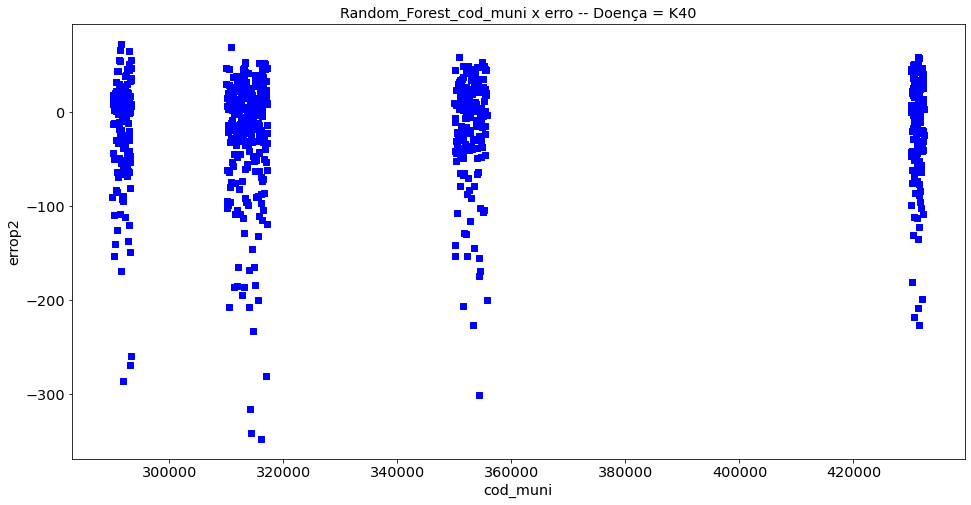

In [26]:
plt.scatter(X_test['cod_muni'], errop2, c = "blue", marker = "s")
plt.title("Random_Forest_cod_muni x erro -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("errop2")
plt.show()

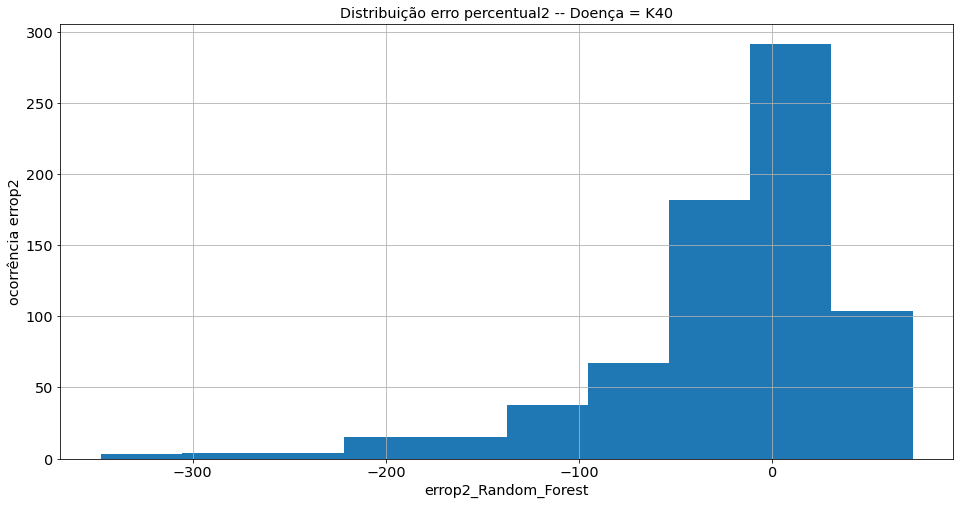

In [28]:
errop2.hist()
plt.title("Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2_Random_Forest")
plt.ylabel("ocorrência errop2")
plt.show()

### Uso inicial dos algoritmos GBoosting

### Otimização de parâmetros

In [31]:
# Light & XG Boosting
params= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max depth': [3,4,5,8,10,11,12],
    'min_child_weigth': [1,3,5,7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]
}

In [32]:
# Gradient Boosting
params0= {
    'min_samples_split': [300,400,500],
    'min_samples_leaf': [30,40,50],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [5,6,7,8],
    'subsample': [0.6,0.7,0.8],
    'learning_rate' : [0.09, 0.1, 0.15]
}

In [33]:
# Adaptative Boosting
params1= {
    'n_estimators': [30,40,50],
    'learning_rate' : [0.09, 0.1, 0.15]
}

In [34]:
# Random Search & Cross Validation
random_search_gbr = RandomizedSearchCV(gbr,param_distributions=params0,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_lgb = RandomizedSearchCV(lgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_xgb = RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_ada = RandomizedSearchCV(ada,param_distributions=params1,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [35]:
random_search_gbr.fit(X_train, y_train)
random_search_lgb.fit(X_train, y_train)
random_search_xgb.fit(X_train, y_train)
random_search_ada.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    3.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.0s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    8.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.0s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\aferr\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   14.7s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.5s finished


[22:34:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { learning rate, max depth, min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   10.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   12.0s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=4,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_lea

In [36]:
print(random_search_gbr.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.09, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=300,
                          min_weight_fraction_leaf=0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)


In [37]:
print(random_search_lgb.best_estimator_)

LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0.1, importance_type='split',
              learning rate=0.4, learning_rate=0.1, max depth=4, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_child_weigth=1,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)


In [38]:
print(random_search_xgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.4, learning_rate=0.1, max depth=5,
             max_delta_step=0, max_depth=4, min_child_weight=1,
             min_child_weigth=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [39]:
print(random_search_ada.best_estimator_)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.09, loss='linear', n_estimators=50,
                  random_

In [40]:
from sklearn.model_selection import cross_val_score
score_gbr=cross_val_score(gbr,X,y,cv=10)
score_lgb=cross_val_score(lgb,X,y,cv=10)
score_xgb=cross_val_score(xgb,X,y,cv=10)
score_ada=cross_val_score(ada,X,y,cv=10)

### Gradient Boosting

In [41]:
m_gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [42]:
m_gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [43]:
y_pred_gbr = m_gbr.predict(X_test)

In [46]:
mse_gbr = round(mean_squared_error(y_test, y_pred_gbr),8)
print(mse_gbr)

4.53e-06


In [47]:
errop2= (y_test - y_pred_gbr)*100/y_test
# em porcentagem

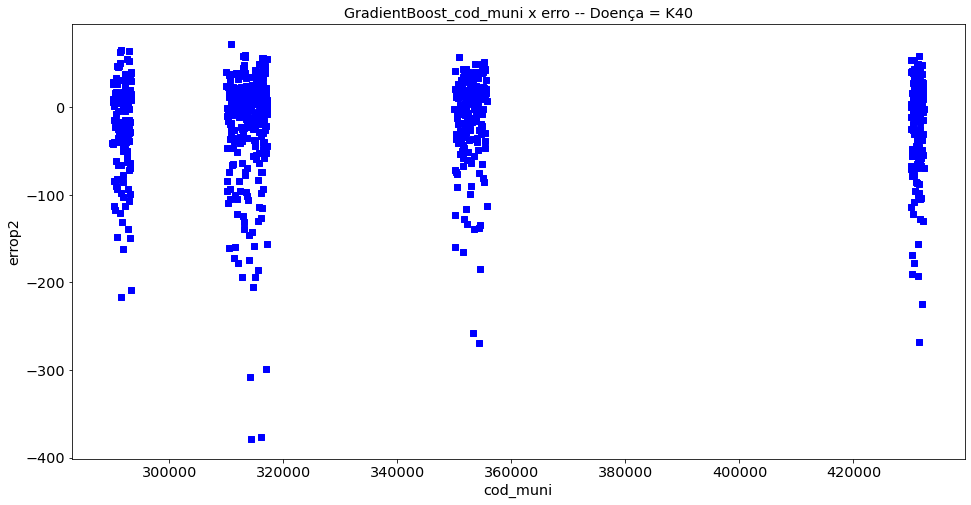

In [48]:
plt.scatter(X_test['cod_muni'], errop2, c = "blue", marker = "s")
plt.title("GradientBoost_cod_muni x erro -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("errop2")
plt.show()

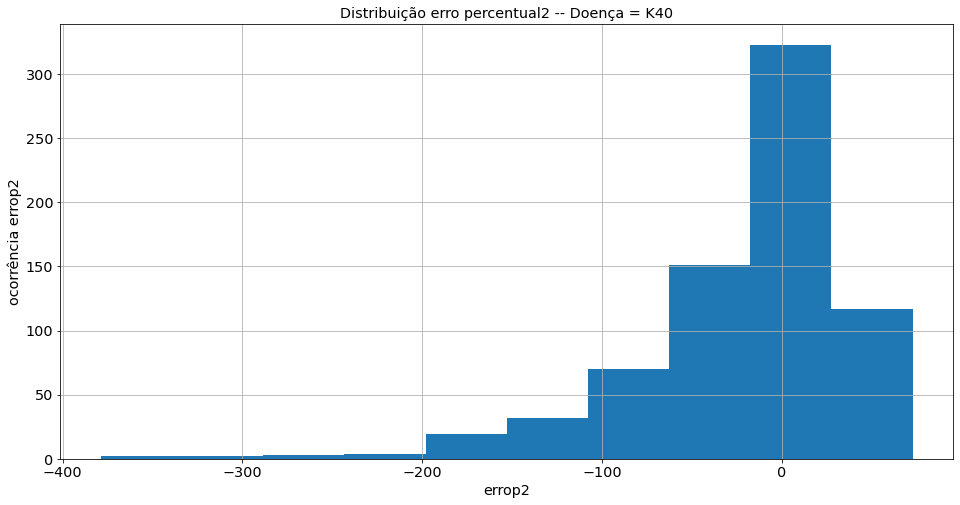

In [49]:
errop2.hist()
plt.title("Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

### Light Gradient Boosting

In [50]:
from lightgbm import LGBMRegressor
m_lgb = LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0.3, importance_type='split',
              learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective='regression', random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [51]:
m_lgb.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
              gamma=0.3, importance_type='split', learning_rate=0.1,
              max_depth=8, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [52]:
y_pred_lgb = m_lgb.predict(X_test)

In [53]:
mse_lgb = round(mean_squared_error(y_test, y_pred_lgb),8)
print(mse_lgb)

4.57e-06


In [54]:
errop2= (y_test - y_pred_lgb)*100/y_test
# em porcentagem

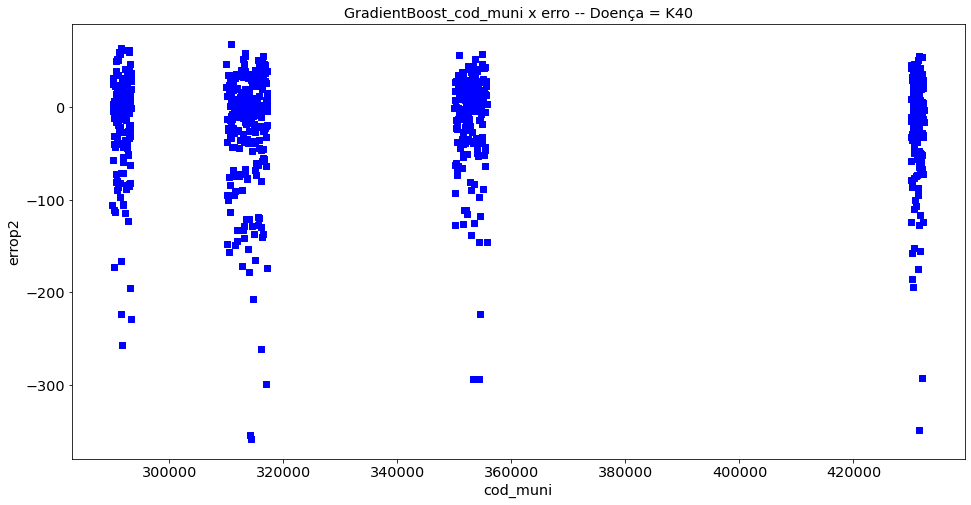

In [55]:
plt.scatter(X_test['cod_muni'], errop2, c = "blue", marker = "s")
plt.title("GradientBoost_cod_muni x erro -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("errop2")
plt.show()

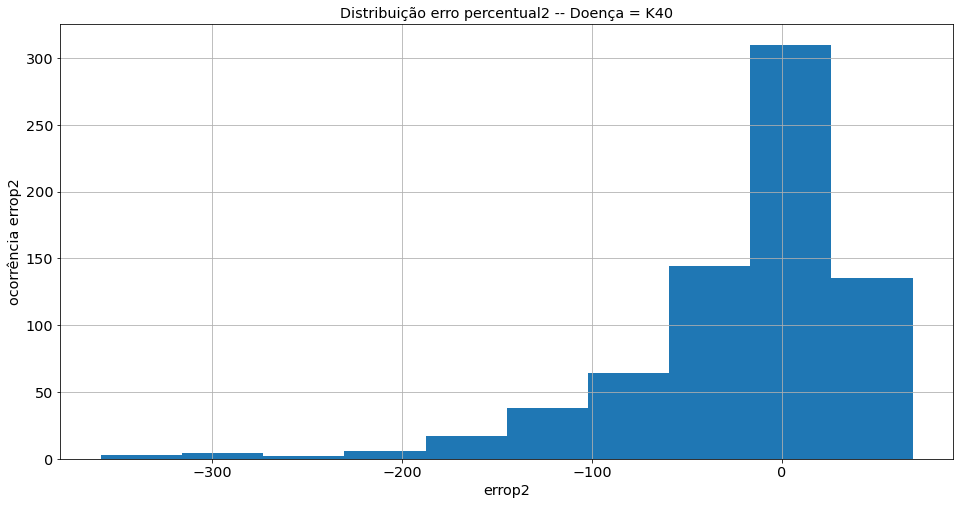

In [56]:
errop2.hist()
plt.title("Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

### XGBoosting

In [57]:
from xgboost import XGBRegressor
m_xgb_1= XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1,
             max_delta_step=0, max_depth=4, min_child_weight=1,
             min_child_weigth=7, missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [58]:
m_xgb_1.fit(X_train,y_train)

[22:36:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, min_child_weigth=7, missing=0.001,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
y_pred_xgb_1= m_xgb_1.predict(X_test)

In [60]:
mse_xgb_1 = round(mean_squared_error(y_test, y_pred_xgb_1),8)
print (mse_xgb_1)

4.46e-06


In [61]:
errop2= (y_test - y_pred_xgb_1)*100/y_test
# em porcentagem

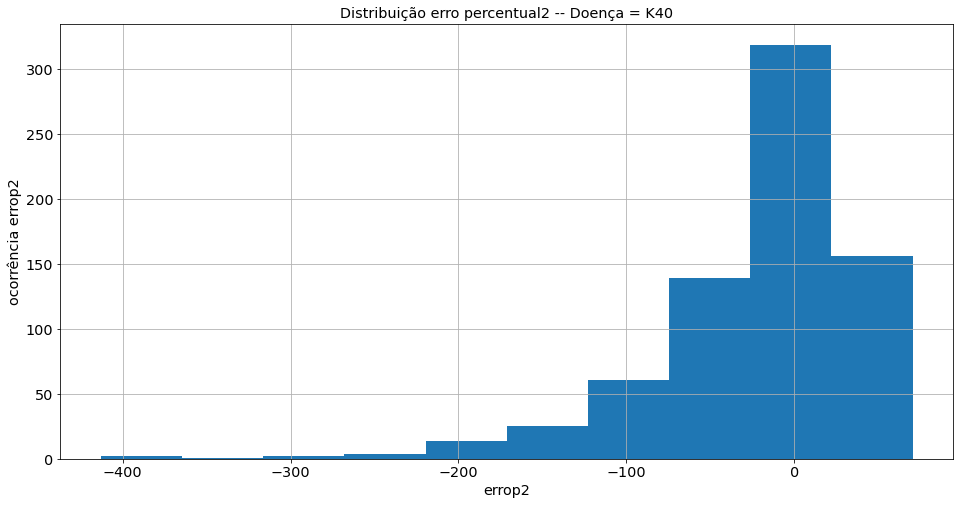

In [62]:
errop2.hist()
plt.title("Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

In [63]:
# Usando parâmetros de arquivo anterior
from xgboost import XGBRegressor
m_xgb_2= XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
m_xgb_2.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
y_pred_xgb_2= m_xgb_2.predict(X_test)

In [66]:
mse_xgb_2 = round(mean_squared_error(y_test, y_pred_xgb_2),8)
print(mse_xgb_2)

4.8e-06


In [67]:
errop2= (y_test - y_pred_xgb_2)*100/y_test
# em porcentagem
media=np.mean(errop2)
desvio=np.std(errop2)
print(media, desvio)

-21.725068221310984 64.08612051148862


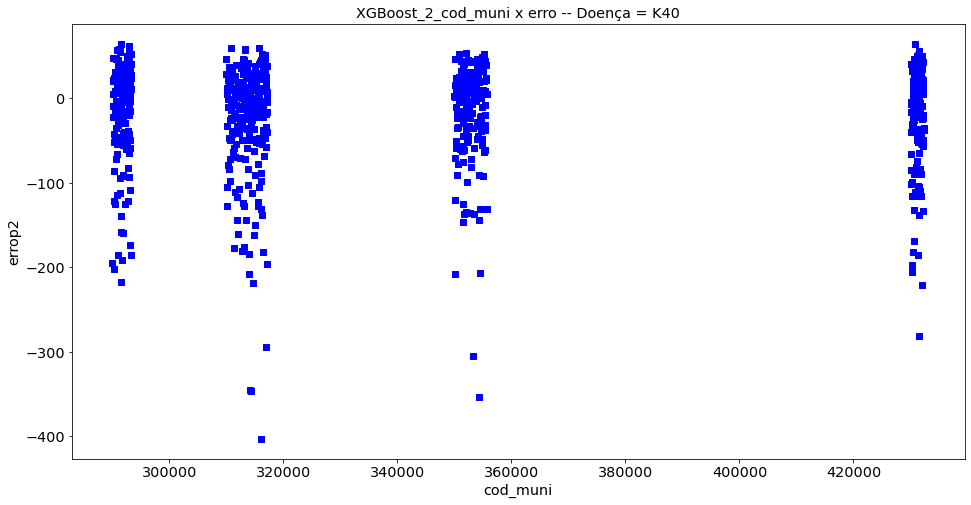

In [68]:
plt.scatter(X_test['cod_muni'], errop2, c = "blue", marker = "s")
plt.title("XGBoost_2_cod_muni x erro -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("errop2")
plt.show()

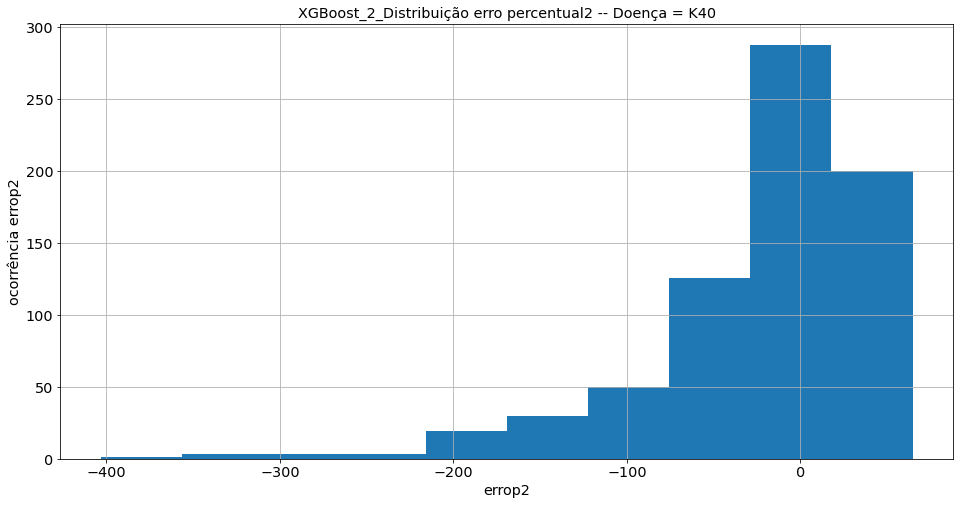

In [69]:
errop2.hist()
plt.title("XGBoost_2_Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

### Adaptative Boosting

In [70]:
m_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.1, loss='linear', n_estimators=40,
                  random_state=None)

In [71]:
m_ada.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.1, loss='linear', n_estimators=40,
                  random_s

In [72]:
y_pred_ada = m_ada.predict(X_test)

In [73]:
mse_ada = round(mean_squared_error(y_test, y_pred_ada),8)
print (mse_ada)

4.73e-06


In [74]:
errop2= (y_test - y_pred_ada)*100/y_test
# em porcentagem

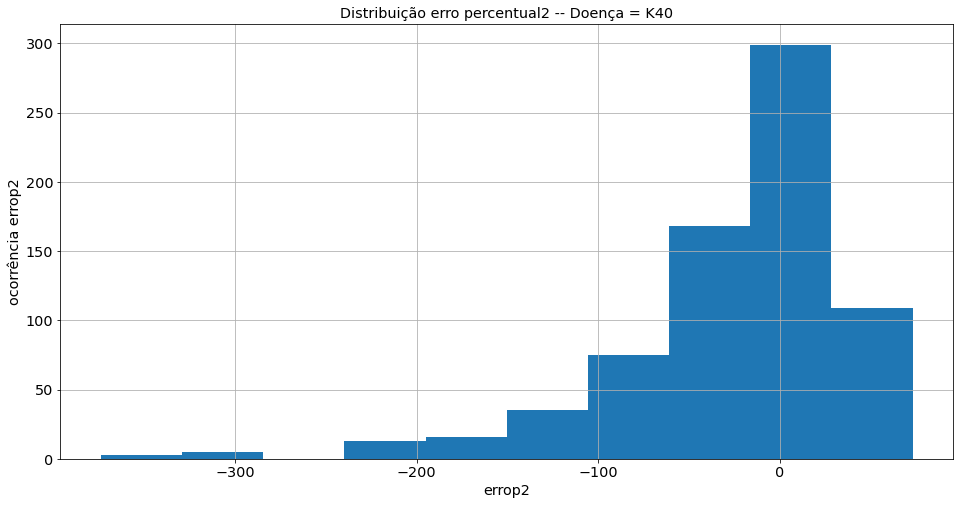

In [75]:
errop2.hist()
plt.title("Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

### Reavaliação das Métricas - uso de acurácia (aplicação relativa)

In [76]:
models=['GradientBoost','LightGBM','XGBoost_1','XGBoost_2','AdaBoost']
Trainning_Accuracy=[m_gbr.score(X_train, y_train),
                    m_lgb.score(X_train, y_train),
                    m_xgb_1.score(X_train, y_train), 
                    m_xgb_2.score(X_train, y_train), 
                    m_ada.score(X_train, y_train)]
Test_Accuracy=[m_gbr.score(X_test, y_test),
                    m_lgb.score(X_test, y_test),
                    m_xgb_1.score(X_test, y_test), 
                    m_xgb_2.score(X_test, y_test), 
                    m_ada.score(X_test, y_test)]
pd.DataFrame(list(zip(Trainning_Accuracy, Test_Accuracy)), 
                  columns =['Trainning_Accuracy', 'Test_Accuracy'],
                  index=models)

Trainning_Accuracy  Test_Accuracy
GradientBoost            0.377942       0.089645
LightGBM                 0.869721       0.083125
XGBoost_1                0.579143       0.104014
XGBoost_2                0.908301       0.036527
AdaBoost                 0.248873       0.051036

In [77]:
models=['Random_Forest','GradientBoost','LightGBM','XGBoost_1','XGBoost_2','AdaBoost']
mse=[mse_rf,mse_gbr,mse_lgb,mse_xgb_1,mse_xgb_2,mse_ada]
pd.DataFrame(list(zip(mse)), columns =['Mean Square Error'], index=models)

Mean Square Error
Random_Forest           0.000005
GradientBoost           0.000005
LightGBM                0.000005
XGBoost_1               0.000004
XGBoost_2               0.000005
AdaBoost                0.000005

### Conclusão = Valores de erros baixos e próximos. Valores de acurácia com diferenças razoáveis. Aprofundar sintonia dos modelos.